# Fake Job Detector – Training Notebook

In this notebook I will:

1. Load the fake job postings dataset
2. Clean the text using my project function (`clean_text`)
3. Turn the text into numbers with TF-IDF
4. Train a Logistic Regression model
5. Check how good the model is
6. Save the model and vectorizer into the `models` folder so my backend and frontend can use them

 ## Imports and Set up

In [15]:
from pathlib import Path
import sys
import joblib
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Detect backend folder (one fixed method)
# So backend folder = parent of pipeline
BACKEND_ROOT = Path().resolve().parents[0]
print("Backend root =", BACKEND_ROOT)

# Add backend root to Python path (so we can import app.utils)
if str(BACKEND_ROOT) not in sys.path:
    sys.path.insert(0, str(BACKEND_ROOT))

# Now import clean_text from your project
from app.utils.text_cleaning import clean_text

# Paths
DATA_PATH = BACKEND_ROOT / "data" / "fake_job_postings.csv"
MODEL_PATH = BACKEND_ROOT / "models" / "fake_job_model.pkl"
VECTORIZER_PATH = BACKEND_ROOT / "models" / "tfidf_vectorizer.pkl"

print("DATA_PATH =", DATA_PATH)
print("MODEL_PATH =", MODEL_PATH)
print("VECTORIZER_PATH =", VECTORIZER_PATH)

Backend root = /Users/rajukotturi45gmail.com/Library/CloudStorage/OneDrive-USNH/Fall - 2025/fake job detector/backend
DATA_PATH = /Users/rajukotturi45gmail.com/Library/CloudStorage/OneDrive-USNH/Fall - 2025/fake job detector/backend/data/fake_job_postings.csv
MODEL_PATH = /Users/rajukotturi45gmail.com/Library/CloudStorage/OneDrive-USNH/Fall - 2025/fake job detector/backend/models/fake_job_model.pkl
VECTORIZER_PATH = /Users/rajukotturi45gmail.com/Library/CloudStorage/OneDrive-USNH/Fall - 2025/fake job detector/backend/models/tfidf_vectorizer.pkl


# Step 2: Load the dataset

In this step we

1. Read the CSV file that contains the job postings.
2. Print the first few rows and basic info so we can see what the data looks like.

In [16]:
# Step 2: Load the dataset

df = pd.read_csv(DATA_PATH)

print("Number of rows:", len(df))
print("\nColumns:", list(df.columns))

# Show a small sample
df.head()

Number of rows: 17880

Columns: ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Step 3: Prepare text and labels

In this step we

1. Combine the job title and job description into one text column.
2. Clean the combined text using `clean_text`.
3. Create the feature series `X` and the label series `y`.

This notebook assumes:
title column is named "title"
description column is named "description"
label column is named "fraudulent"
where fraudulent is 1 for fake job and 0 for real job.

In [17]:
# Step 3: Prepare text and labels

title_col = "title"
desc_col = "description"
label_col = "fraudulent"

# Combine title and description into one text field
df["text"] = (
    df[title_col].fillna("") + " " + df[desc_col].fillna("")
).str.strip()

# Apply our cleaning function from app.utils.text_cleaning
df["text_clean"] = df["text"].apply(clean_text)

# Features and labels
X = df["text_clean"]
y = df[label_col].astype(int)

print("Example cleaned text:")
print(X.iloc[0])
print("\nLabel value counts:")
print(y.value_counts())

Example cleaned text:
marketing intern food a fastgrowing james beard awardwinning online food community and crowdsourced and curated recipe hub is currently interviewing full and parttime unpaid interns to work in a small team of editors executives and developers in its new york city headquartersreproducing andor repackaging existing food content for a number of partner sites such as huffington post yahoo buzzfeed and more in their various content management systemsresearching blogs and websites for the provisions by food affiliate programassisting in daytoday affiliate program support such as screening affiliates and assisting in any affiliate inquiriessupporting with pr amp events when neededhelping with office administrative work such as filing mailing and preparing for meetingsworking with developers to document bugs and suggest improvements to the sitesupporting the marketing and executive staff

Label value counts:
fraudulent
0    17014
1      866
Name: count, dtype: int64


# Step 4: Split into train and test sets

In this step we

1. Split the cleaned text and labels into training and testing sets.
2. Keep 20 percent of the data for testing.
3. Use a fixed random state so the split is repeatable.

In [18]:
# Step 4: Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training size:", len(X_train))
print("Test size:", len(X_test))

Training size: 14304
Test size: 3576


# Step 5: Vectorize text with TF IDF

In this step we

1. Create a TF IDF vectorizer.
2. Fit it on the training text.
3. Transform both training and test text into numeric vectors.

These numeric vectors are what the machine learning model will use.

In [19]:
# Step 5: Vectorize text with TF IDF

vectorizer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    stop_words="english",
)

print("Fitting vectorizer on training text...")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Shape of training matrix:", X_train_vec.shape)
print("Shape of test matrix:", X_test_vec.shape)

Fitting vectorizer on training text...
Shape of training matrix: (14304, 30000)
Shape of test matrix: (3576, 30000)


# Step 6: Train the model

In this step we

1. Create a Logistic Regression classifier.
2. Train it on the TF IDF features.
3. This model will output how likely a job posting is fake.

In [29]:
# Step 6: Train the model (with visual model summary)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

print("Training model...")
model.fit(X_train_vec, y_train)
print("Model training finished.")

# Show model summary visually
model

Training model...
Model training finished.


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# Step 7: Evaluate the model

In this step we

1. Use the trained model to predict labels on the test set.
2. Compute accuracy.
3. Print a full classification report so we can see precision, recall and f1 score.

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3403
           1       0.62      0.83      0.71       173

    accuracy                           0.97      3576
   macro avg       0.81      0.90      0.85      3576
weighted avg       0.97      0.97      0.97      3576



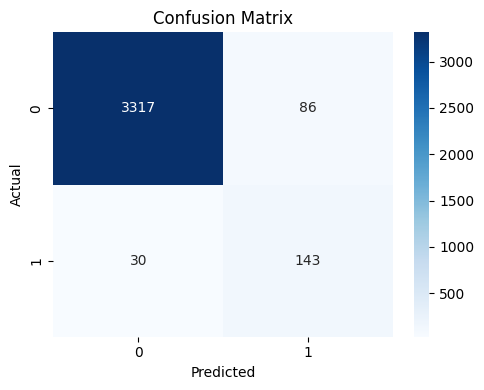

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# y_pred should already be computed earlier:
# y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Step 8: Save model and vectorizer to the models folder

In this step we

1. Save the trained model as `fake_job_model.pkl`.
2. Save the fitted TF IDF vectorizer as `tfidf_vectorizer.pkl`.
3. Both files are stored in the `backend/models` folder so the FastAPI backend and the Streamlit app can load them later.

In [24]:
# Step 8: Save model and vectorizer to the models folder

MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(model, MODEL_PATH)
joblib.dump(vectorizer, VECTORIZER_PATH)

print("Saved model to:", MODEL_PATH)
print("Saved vectorizer to:", VECTORIZER_PATH)

Saved model to: /Users/rajukotturi45gmail.com/Library/CloudStorage/OneDrive-USNH/Fall - 2025/fake job detector/backend/models/fake_job_model.pkl
Saved vectorizer to: /Users/rajukotturi45gmail.com/Library/CloudStorage/OneDrive-USNH/Fall - 2025/fake job detector/backend/models/tfidf_vectorizer.pkl


# Step 9: Quick sanity check

In this optional step we

1. Load one example text from the test set.
2. Run it through the vectorizer and model.
3. Print the predicted label so we can see that the full pipeline works.

Label 1 means fake job.
Label 0 means real job.

In [27]:
# Step 9: Quick sanity check

example_text = X_test.iloc[0]
example_label = y_test.iloc[0]

print("Original cleaned text:")
print(example_text)
print("\nTrue label:", example_label)

example_vec = vectorizer.transform([example_text])
example_pred = model.predict(example_vec)[0]
example_proba = model.predict_proba(example_vec)[0][1]

print("Predicted label:", example_pred)
print("Predicted fake probability:", round(float(example_proba), 3))

Original cleaned text:
excellent er rn opportunity available now our client located in urban il is looking for an er rn to become a member of their team asapour client is an institution of high quality care medical research and education they serve people our client is a healthcare leader in central illinois as a level trauma center and bed magnet hospital our client’s employees reflect the organization’s values integrity collaboration accountability respect excellence through their efforts to improve the health of the people we serve by providing worldclass healthcarework environmentfully integrated epic electronic medical recordsstateoftheart facilitiestuition assistance and continuing medical education opportunities for full and parttime employeesformal mentoring program available to ease employee transitionsmagnet designation since incentives to join their team• up to a signon bonus – limited time offer• relocation for miles and relocation for miles• enhanced rn compensation plan b